[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/spherical_flow_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow healpy

-------------------
## Spherical example

This example notebook demonstrates using `pzflow` to model data on a sphere (specifically the Earth).
This is more complicated, as two of our variables, specifically latitude and longitude, belong to a space with non-Euclidean topology.
Therefore, we cannot just draw from a multivariate Gaussian in $\mathbb{R}^n$ and hope that our bijector will model the distribution well.

Unlike the other variables we have considered, latitude and longitude belong to a compact domain, and longitude is periodic.
We will address this below by drawing both variables from uniform distributions with compact support, and we will transform longitude with periodic splines.

For more basic `pzflow` usage, see the [intro notebook](https://github.com/jfcrenshaw/pzflow/blob/main/examples/intro.ipynb) and the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from pzflow import Flow
from pzflow.bijectors import Chain, NeuralSplineCoupling, Roll, StandardScaler
from pzflow.distributions import Joint, Normal, Uniform
from pzflow.examples import city_data

First let's load the city data included with pzflow.

In [2]:
cities = city_data()
cities

,Country,City,Population,Latitude,Longitude
0,Andorra,Andorra la Vella,20430.0,42.500000,1.516667
1,Andorra,Canillo,3292.0,42.566667,1.600000
2,Andorra,Encamp,11224.0,42.533333,1.583333
3,Andorra,La Massana,7211.0,42.550000,1.516667
4,Andorra,Les Escaldes,15854.0,42.500000,1.533333
...,...,...,...,...,...
47961,Zimbabwe,Redcliffe,38231.0,-19.033333,29.783333
47962,Zimbabwe,Rusape,23761.0,-18.533333,32.116667
47963,Zimbabwe,Shurugwi,17107.0,-19.666667,30.000000
47964,Zimbabwe,Victoria Falls,36702.0,-17.933333,25.833333


We can see we have a list of about 48,000 cities, along with their locations and populations.
We will use this to approximately model the population density of the Earth.

Let's convert the angles to radians and calculate the logarithm of the populations.
In addition, let's convert latitude to a zenith angle, and longitude so that its range is $[0,2\pi]$ instead of $[-\pi,+\pi]$.

In [3]:
logpop = np.log10(cities['Population'].values)
theta = np.radians(90 - cities['Latitude'].values)
phi = np.radians(180 + cities['Longitude'].values)

Let's use `healpy` to plot a Mollweide projected histogram of our data.

In [4]:
def mollweide_hist(theta, phi, weights=None, nside=64, **kwargs):
    """Make a healpix histogram with a Mollweide projection.
    
    theta : array
        Array of zenith angles.
    phi : array
        Array of azimuth angles.
    weights : array
        Weight of each point.
    nside : int, default=64
        HEALPix nside of the target map
    """
    
    if weights is not None:
        theta = np.repeat(theta, np.rint(weights).astype(int))
        phi = np.repeat(phi, np.rint(weights).astype(int))
    
    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi - np.pi)
    idx, counts = np.unique(indices, return_counts=True)
    npix = hp.nside2npix(nside)
    
    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    # plot histogram
    hp.mollview(np.log10(hpx_map+1), **kwargs)

/phys/users/jfc20/.conda/envs/pzflow/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/phys/users/jfc20/.conda/envs/pzflow/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/phys/users/jfc20/.conda/envs/pzflow/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In futur

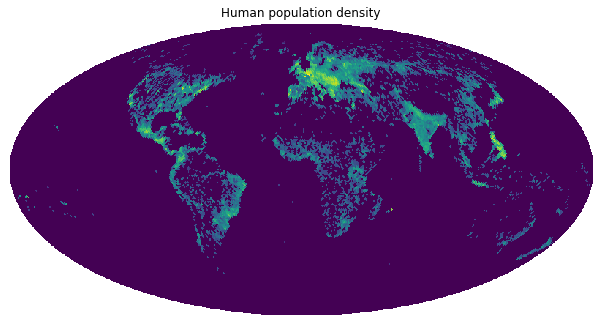

In [5]:
mollweide_hist(theta, phi, 
               weights=logpop, 
               nside=64, 
               title="Human population density", 
               flip="geo", 
               cbar=False)

Now we want to model this data with a normalizing flow. As we mentioned above, the latitude and longitude variables must be treated with special care, as the live in $S^2$ instead of $\mathbb{R}^2$.
However, the sphere $S^2$ can be decomposed into an interval and a circle. In other words, the map $(\theta, \phi) \to (\cos(\theta), \phi)$ maps the sphere to a cylinder, $S^2 \to [-1,1] \times S^1$.

What this means is we can model $\cos(\theta)$ in the usual way, as long as we map it to a latent distribution with compact support, e.g. the uniform distribution $\mathcal{U}(-3, 3)$.

However, $\phi$ still lives on the circle. Fear not, we can still model $\phi$ with our usual bijectors, as long as we enforce the following boundary conditions:
$$ f(0) = 0, \quad f(2\pi) = 2\pi, \quad \nabla\! f(0)= \nabla\! f(2\pi), \quad \nabla\! f(\phi) > 0.$$
We will see that these conditions are easy to impose with our Neural Spline Coupling. 

First, lets create a DataFrame with our transformed data:

In [6]:
data = pd.DataFrame(np.array([phi, np.cos(theta), logpop]).T, columns=("phi", "cos(theta)", "logpop"))

Before we talk about the bijector, let's create the latent distribution.

We are going to use $\mathcal{U}(-3, 3)$ for the latent distribution of $\cos(\theta)$ and $\phi$. 
As a reminder -- we are using uniform distributions because distributions that match the compact support of $\cos(\theta)$ and $\phi$.

It may seem confusing why I chose $[-3, +3]$ for both, instead of $[-1, +1]$ and $[0, 2\pi]$.
This is because in the bijector we will use Neural Spline Couplings (see below), whose default extent is $[-3, +3]$ (i.e. `B=3` by default). So it makes sense to choose a latent distribution that takes full advantage of this range.

For `logpop` we can just use a regular Normal distribution, like we have before.

We can create a joint distribution out of these Uniform and Normal distributions, but we have to take care that the bijector matches up the data variables with the correct dimension of the latent space.

In [8]:
latent = Joint(Uniform((-3,3), (-3,3)), Normal(1))

In particular, with this joint distribution, the Normal distribution is last, so we need to make sure that after the bijector is applied, the latent dimension corresponding to `logpop` is in the last column.

Now let's create the bijector.

First, we will apply standard scaling to `logpop`.
We can also "cheat" and use the standard scaling to map the ranges of $\cos(\theta)$ and $\phi$ onto $[-3, +3]$ (I say "cheat" because this isn't really what StandardScaler is for - it's meant to ensure a mean of zero and variance of one - but it's easy to choose fake "means" and "standard deviations" for $\cos(\theta)$ and $\phi$ so that it maps them onto the correct domain).

Then we will chain a handful of Neural Spline Couplings. Note that unlike in the [redshift example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb), we cannot use the `RollingSplineCoupling` shortcut, because the $\phi$ dimension needs to be treated specially.

First I apply a regular `NeuralSplineCoupling` twice (with `Roll` interspersed) to transform the non-periodic dimensions of `logpop` and $\cos(\theta)$.
I set `transformed_dim=1` to specify that only the last column is transformed.
Since the data columns in `data` are `("phi", "cos(theta)", "logpop")`, this means that the first `NeuralSplineCoupling` transforms `logpop`, and the second (after the `Roll`) transforms $\cos(\theta)$. 
Thus after the second `Roll`, $\phi$ is now in the last column.

We can now apply a `NeuralSplineCoupling` with `periodic=True`.
This is all we have to do to enforce the periodic constraints we listed above!

After one more `Roll`, all of the columns are back in the same order they started in.
This is important, as it ensures that each dimension lines up the correct dimension of the latent space that we set up above.

In [9]:
means = np.array([np.pi, 0, data['logpop'].mean()])
stds = np.array([np.pi/3, 1/3, data['logpop'].std()])

bijector = Chain(
    StandardScaler(means, stds), 
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1),
    Roll(),
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1),
    Roll(),
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1, periodic=True),
    Roll(),
)

Now we can create the flow by providing the names of our data columns, the bijector, and the latent space.

In [10]:
flow = Flow(data.columns, bijector, latent=latent)

Let's train it!

In [11]:
%%time
losses = flow.train(data, epochs=100, verbose=True)

Training 100 epochs 
Loss:
3.6009
2.6042
1.2661
0.9495
0.7495
0.6268
0.5463
0.5234
0.4364
0.3851
0.3611
0.3158
0.2646
1.4889
0.4196
0.2861
0.2608
0.2868
0.1901
0.1781
0.1833
CPU times: user 45min 34s, sys: 34min 52s, total: 1h 20min 26s
Wall time: 11min 54s


Let's plot the training losses to make sure everything looks okay.

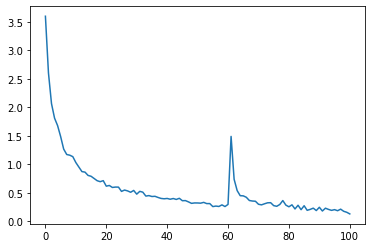

In [12]:
plt.plot(losses)

Now let's draw samples from the latent space, and samples from the trained flow, and plot them together with the truth data.

In [13]:
# sample from the raw latent distribution
latent_samples = flow.latent.sample(flow.latent._params, data.shape[0], seed=0)
latent_theta = np.arccos(latent_samples[:,0]/3)
latent_phi = latent_samples[:,1]*(np.pi/3)
latent_logpop = (latent_samples[:,2] * data['logpop'].std() + data['logpop'].mean()).astype(float)

# sample from the trained flow
samples = flow.sample(data.shape[0], seed=0)

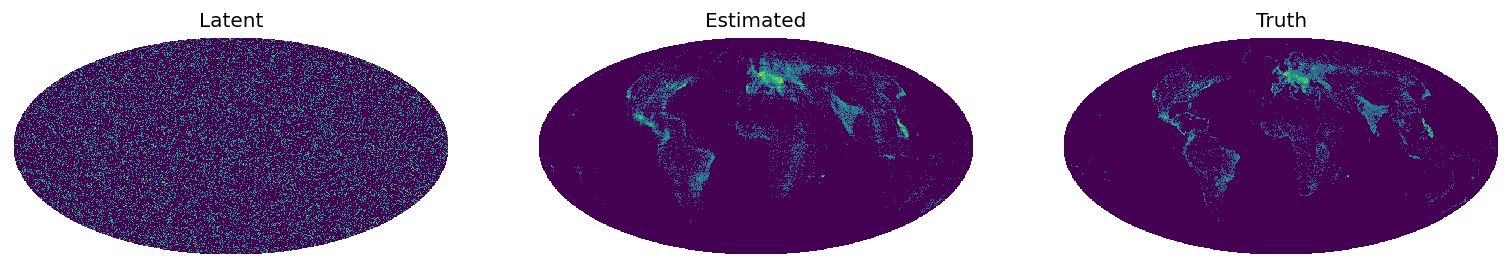

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), dpi=120)

nside = 128
flip = "geo"
cbar = False

# latent samples
plt.axes(ax1)
mollweide_hist(latent_theta,
               latent_phi,
               weights=latent_logpop,
               title="Latent",
               nside=nside,  
               flip=flip, 
               cbar=cbar,
               hold=True)

# trained flow
plt.axes(ax2)
mollweide_hist(np.arccos(samples["cos(theta)"].values),
               samples["phi"].values,
               weights=samples["logpop"],
               title="Estimated",
               nside=nside,  
               flip=flip, 
               cbar=cbar,
               hold=True)

# truth
plt.axes(ax3)
mollweide_hist(theta,
               phi,
               weights=logpop,
               title="Truth",
               nside=nside,  
               flip=flip, 
               cbar=cbar,
               hold=True)

Pretty good for a simple network with no hyperparameter tuning!